<h1> <a> Apprentissage </a> </h1>
<h2> Pour le Challenge Axa </h2>
<h3> Axa Graduate Program Février 2017 </h3>
<i> Author : Paul Tran </i> <br>


--------------

# Sommaire
1. [Préliminaires](#préliminaires)
    1. [Introduction](#introduction)
    2. [Imports](#imports)
    3. [Chargement de la donnée](#load)
2. [Data Management](#management)
    1. [Régression sur valeurs manquantes](#nan)
    2. [Traitement outliers](#traitement)
    3. [Train, Validation & Test](#split)

3. [Machine Learning](#ML)
    1. [Méthode Linéaire](#linéaire)
        1. [Régression Linéaire simple](#lr)
        2. [Lasso](#lasso)
    2. [Méthodes ensemblistes](#ensemblistes)
        1. [Random Forest](#RF)
        2. [Extra Trees](#ET)
        3. [XG Boost](#XGB)
4. [Datamagement](#datamanagement)
    1. [Valeurs Manquantes](#missing)
    2. [Encodage disjonctif complet](#dummies)
    3. [Clustering](#kmeans)

------------

# Préliminaires  <a name="préiliminaires"></a>

- ## Introduction :  <a name="introduction"></a>

Dans cette partie nous allons gérer chercher à traiter plus intelligemment la donnée:
- remplir les valeurs manquantes plus intelligemment
- retraiter les extremas (outliers)
- tenter de dériver des features

- ## Précautions

Ce notebook prend beaucoup de temps à être exécuté dans son intégralité du fait des apprentissages successifs qui sont lancés. Il est conseiller de ne pas l'exécuter et d'observer directement les résultats des cellules. De plus ce notebook sera très similaire au précédant en terme de machine learning, seule la partie préprocessing change.

En effet, le gain de performance est bien plus important en traitant la donnée qu'en tunant le modèle.

- ## Imports des librairies utiles <a name="imports"></a>

In [1]:
import os
import math
import pandas as pd
pd.set_option('display.max_columns', 300)
import numpy as np


#pour la partie data viz
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
#import bokeh
#from bokeh.io import output_notebook
#output_notebook()

from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn import preprocessing

- ## Chargement de la donnée  <a name="load"></a>

***Nous chargeons les données traitées préalablement (depuis le Notebook Ch1), cela évite de devoir réécrire tout le code du premier Notebook dans celui-ci.***

In [2]:
%store -r data_raw01
#Récupération de la variable data depuis le Notebook stocké précédemment.
#Cette fois ci, nous conservons les départements.

In [3]:
#Nous n'observons que le début de la table pour s'assurer qu'elle s'est bien chargée.
data_raw01.head()

,Age,Benefice net annuel,Categorie socio professionnelle,Coefficient bonus malus,Cout entretien annuel,Kilometres parcourus par mois,Marque,Niveau de vie,Prime mensuelle,Salaire annuel,Score CRM,Score credit,Type de vehicule
index,,,,,,,,,,,,,
0,58.0,54.998558,Etudiant,106,801,973,Peugeot,3762,40.0,20420,164,309,SUV
1,26.0,7.840930,Ouvrier,95,667,637,Renault,3445,27.0,25750,126,135,5 portes
2,27.0,46.078889,Cadre,136,696,978,Renault,986,26.0,6790,153,786,SUV
3,22.0,-11.048213,Etudiant,96,765,771,Peugeot,2366,8.0,15140,111,320,3 portes
4,60.0,1.180078,Sans emploi,101,808,758,Peugeot,1441,20.0,12850,149,287,3 portes


# I. Data management  <a name="management"></a>

- - ### Régression sur les données manquantes <a name="nan"></a>

***Premier traitement, devenu classique : nous listons les variables dotées de valeurs manquantes (des NAN en l'occurence).***

In [4]:
#Vérifier les colonnes concernées [possédant des NaN]
for element in data_raw01.isnull().sum().index:
    if data_raw01[element].isnull().sum()!=0:
        print (element)

Age
Benefice net annuel
Marque
Prime mensuelle


***On cherche les variables catégorielles qui ne possèdent pas de valeurs nulles afin de les "dummiser" (encodage disjonctif complet).***

In [5]:
#Vérifier les colonnes qui sont de type objet
list_categorical=[]
for element in data_raw01.columns:
    if data_raw01[element].dtype==np.object:
        list_categorical.append(element)
        print('La variable %s est de type Object.' %(element))

La variable Categorie socio professionnelle est de type Object.
La variable Marque est de type Object.
La variable Type de vehicule est de type Object.


In [6]:
data_raw01 = pd.get_dummies(data_raw01, columns=['Categorie socio professionnelle',
                                                 'Type de vehicule'],drop_first=True)
data_raw01.shape

(1300, 18)

In [7]:
#print pour s'assurer du résultat
data_raw01.head()

,Age,Benefice net annuel,Coefficient bonus malus,Cout entretien annuel,Kilometres parcourus par mois,Marque,Niveau de vie,Prime mensuelle,Salaire annuel,Score CRM,Score credit,Categorie socio professionnelle_Etudiant,Categorie socio professionnelle_Ouvrier,Categorie socio professionnelle_Sans emploi,Categorie socio professionnelle_Travailleur non salarie,Type de vehicule_5 portes,Type de vehicule_SUV,Type de vehicule_Utilitaire
index,,,,,,,,,,,,,,,,,,
0,58.0,54.998558,106,801,973,Peugeot,3762,40.0,20420,164,309,1,0,0,0,0,1,0
1,26.0,7.840930,95,667,637,Renault,3445,27.0,25750,126,135,0,1,0,0,1,0,0
2,27.0,46.078889,136,696,978,Renault,986,26.0,6790,153,786,0,0,0,0,0,1,0
3,22.0,-11.048213,96,765,771,Peugeot,2366,8.0,15140,111,320,1,0,0,0,0,0,0
4,60.0,1.180078,101,808,758,Peugeot,1441,20.0,12850,149,287,0,0,1,0,0,0,0


***On va désormais régresser les variables numériques manquantes à partir de la matrice de données complète.***

In [8]:
#Nous régressons sur les variables contenant des NaN
test = data_raw01
l=['Age','Prime mensuelle']
for element in l:
    temp = test.copy(deep=True)
    del temp['Benefice net annuel']
    del temp['Marque']
    for e in [x for x in l if x!=element]:
        del temp[e]
    columns1 = list(temp.columns)
    columns1.remove(element)
    #retrouver les indices des lignes avec des nan pour la variable en question
    index = data_raw01[element].index[data_raw01[element].apply(np.isnan)]
    #drop les lignes
    temp = temp.drop(temp.index[index])
    lr = LinearRegression()
    lr.fit(temp[columns1], temp[element])

    for idx in index:
        X= data_raw01.iloc[idx][columns1]
        y_lr = lr.predict(X.values.reshape(1, -1))
        #print(y_lr[0])
        data_raw01.ix[idx,element]=y_lr[0]
    print('Régression achevée pour la variable : %s.') %(element)

Régression achevée pour la variable : Age.
Régression achevée pour la variable : Prime mensuelle.


In [9]:
for element in data_raw01.isnull().sum().index:
    if data_raw01[element].isnull().sum()==0 and element=='Age' and element!='Benefice net annuel':
        #data_raw01[element] = data_raw01[element].fillna(data_raw01[element].median())
        print("L'age ne comporte plus de champs vides.")
    if data_raw01[element].isnull().sum()==0 and element=='Prime mensuelle' and element!='Benefice net annuel':
        #data_raw01[element] = data_raw01[element].fillna(data_raw01[element].median())
        print("La Prime mensuelle ne comporte plus de champs vides.")
    if data_raw01[element].dtype==np.object:
        data_raw01[element]=data_raw01[element].fillna(data_raw01[element].describe().top)#remplacer par sa valeur top

data_raw01 = pd.get_dummies(data_raw01, columns=['Marque'],drop_first=True)   

L'age ne comporte plus de champs vides.
La Prime mensuelle ne comporte plus de champs vides.


- - ### Gestion des outliers <a name="traitement"></a>

In [10]:
data_raw01[data_raw01['Salaire annuel']>90000]['Salaire annuel'] #38580

index
92      165760
181     118750
201      98360
326      91390
442      95780
528     120120
734     125490
788      99340
834      93780
1183    133980
Name: Salaire annuel, dtype: int64

In [11]:
#Cette modification est due à une forte interprétation métier
#Le choix se portant sur l'age car il est juste impossible ou aberrant d'avoir un client à 0 an
    #ou a 198 ans
def traiter_age(x):
    if x<18:
        return 18
    if x>99:
        return 99
    return x

def traiter_salaire(x,threshold):
    if x>threshold:
        return threshold
    return x

data_raw01['Age'] = data_raw01['Age'].apply(lambda x: traiter_age(x))
#data_raw01['Salaire annuel'] = data_raw01['Salaire annuel'].apply(lambda x: traiter_salaire(x,100000))

- ## Train, Validation & Test set  <a name="split"></a>

***La donnée étant déjà traité de façon la plus simple depuis le premier Notebook, nous nous contentons pour notre première approche "naïve" de simplement séparer notre base de train afin de pouvoir évaluer le modèle d'apprentissage.***

***Nous la considérons "naïve", dans la mesure où nous nous sommes seulement contentés de remplacer les NaN par la moyenne des valeurs existantes (pour les variables quantitatives). Le traitement des données est indispensable afin que le modèle d'apprentissage accepte le format des données en entrée.***

In [12]:
def simple_split(X):
    to_drop=['Benefice net annuel'] #on enlève la cible
    T=X[1000:]
    X=X[0:1000]  
    return X.drop(to_drop,axis=1),X['Benefice net annuel'],T.drop(to_drop,axis=1)


- ## Data split

In [13]:
%%time
X,y,T=simple_split(data_raw01.copy())

CPU times: user 14 ms, sys: 3.75 ms, total: 17.8 ms
Wall time: 3.08 ms


# II. Machine learning  <a name="ML"></a>

Here comes the juicy part!

***Avant d'entrer dans le coeur du machine learning, il est nécessaire de définir une métrique d'évaluation.***

In [14]:
from sklearn.metrics import mean_squared_error
from math import sqrt

# RMSE :root-mean-square error
def RMSE(y_true, y_pred): 
    return sqrt(mean_squared_error(y_true, y_pred))


# Mean Absolute Percentage Error
def mape_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

***Nous allons scinder la base de train afin de pouvoir évaluer le modèle, par l'intermédiaire de la méthode de validation croisée.***

In [15]:
random_state = 42 #set seed pour l'ensemble

In [16]:
from sklearn.cross_validation import train_test_split
X0_train,X0_test,y0_train,y0_test=train_test_split(X,y,test_size=0.2,random_state=42)

import sklearn
from sklearn.cross_validation import train_test_split, KFold
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn import grid_search
from sklearn.model_selection import GridSearchCV

/usr/local/anaconda2/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/usr/local/anaconda2/lib/python2.7/site-packages/sklearn/grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


- ## A. Méthode Linéaire  <a name="linéaire"></a>
    - Approche la plus naïve

In [17]:
%%time
#Apprentissage:
lr = LinearRegression()
lr.fit(X0_train, y0_train)

#Prédiction:
y_lr = lr.predict(X0_test)

CPU times: user 9.95 ms, sys: 3 ms, total: 12.9 ms
Wall time: 2.21 ms


In [18]:
#Evaluation du modèle :
print("L'erreur type (RMSE) est de %s") %(RMSE(y0_test, y_lr))
print("La moyenne absolue de pourcentage d'erreur est de %s %%") %(mape_error(y0_test, y_lr))

L'erreur type (RMSE) est de 7.14094529481
La moyenne absolue de pourcentage d'erreur est de 82.1890725883 %


- ## A. Méthode Linéaire  <a name="lr"></a>
    - Approche polynomiale et cross validation

In [19]:
def k_fold_cross_val_poly(folds, degrees, X, y):
    #fonction qui calcule les scores RMSE pour K-fold et d degré polynomial
    n = len(X)
    kf = KFold(n, n_folds=folds,random_state=42)
    #creation du dico qui retient les scores RMSE
    kf_dict = dict([("fold_%s" % i,[]) for i in range(1, folds+1)])
    fold = 0
    for train_index, test_index in kf:
        fold += 1
        #print "Fold: %s" % fold
        X_train, X_test = X.ix[train_index], X.ix[test_index]
        y_train, y_test = y.ix[train_index], y.ix[test_index]
        # Incrémente le dégré polynomial
        for d in range(1, degrees+1):
            #print "Degree: %s" % d
            # Model & fit
            polynomial_features = PolynomialFeatures(
                degree=d, include_bias=False
            )
            linear_regression = LinearRegression()
            model = Pipeline([
                ("polynomial_features", polynomial_features),
                ("linear_regression", linear_regression)
            ])
            model.fit(X_train, y_train)
            # Calcul du RMSE
            y_pred = model.predict(X_test)
            test_rmse = RMSE(y_test, y_pred)
            #print test_rmse
            kf_dict["fold_%s" % fold].append(test_rmse) #stockage dans le dict
        # Transform en np.array pour le moyenner
        kf_dict["fold_%s" % fold] = np.array(kf_dict["fold_%s" % fold])
    #Dans le dico
    kf_dict["avg"] = np.zeros(degrees)
    for i in range(1, folds+1):
        kf_dict["avg"] += kf_dict["fold_%s" % i]
    kf_dict["avg"] /= float(folds)
    return kf_dict

def plot_test_error_curves_kf(kf_dict, folds, degrees):
    #fonction qui permet de visualiser les résultats calculés par la fonction ci-dessus
    fig, ax = plt.subplots(figsize=(10, 10))
    ds = range(1, degrees+1)
    for i in range(1, folds+1):
        ax.plot(ds, kf_dict["fold_%s" % i], lw=2, label='Test RMSE - Fold %s' % i)
    ax.plot(ds, kf_dict["avg"], linestyle='--', color="black", lw=3, label='Avg Test RMSE')
    ax.legend(loc=0)
    ax.set_xlabel('Degree of Polynomial Fit')
    ax.set_ylabel('RMSE')
    #ax.set_ylim([0.0, 4.0])
    fig.set_facecolor('white')
    plt.show()

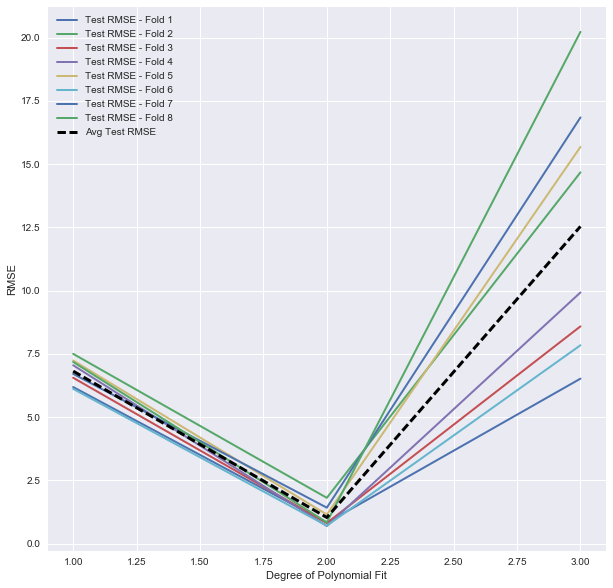

In [20]:
# Plot la courbe d'erreur k-fold CV set
folds = 8
degrees = 3
kf_dict = k_fold_cross_val_poly(folds, degrees, X, y)
plot_test_error_curves_kf(kf_dict, folds, degrees)

In [21]:
print('Le régresseur polynomial atteint une valeur moyenne minimale RMSE : %s pour un degré %s'
      %(kf_dict['avg'].min(),kf_dict['avg'].argmin()+1))

Le régresseur polynomial atteint une valeur moyenne minimale RMSE : 1.02976361833 pour un degré 2


- > *** Intreprétation: on décide de choisir un degré polynomial de 2. ***

In [22]:
# Sélection du model:

lr = LinearRegression() #init
polynomial_features = PolynomialFeatures(degree=2, include_bias=False)
# Création du pipeline
pipe = Pipeline([("polynomial_features", polynomial_features),
        ("linear_regression", lr)])
grid = dict(linear_regression__normalize=[False,True]) #espace de paramètre de la régression
                                                        # choix sur la normalisation
model = GridSearchCV(pipe,param_grid=grid,cv=8)
model.fit(X0_train, y0_train)
#predict
y_lr = model.predict(X0_test)

In [23]:
#Evaluation du modèle :
print("L'erreur type (RMSE) est de %s") %(RMSE(y0_test, y_lr))
print("La moyenne absolue de pourcentage d'erreur est de %s %%") %(mape_error(y0_test, y_lr))
print("Meilleur model utilisant %s." % ( model.best_params_))

L'erreur type (RMSE) est de 1.02427397696
La moyenne absolue de pourcentage d'erreur est de 12.5011384989 %
Meilleur model utilisant {'linear_regression__normalize': False}.


***Nous obtenons un pourcentage d'erreur d'environ 13 % et une RMSE de 1.06 légèrement ce qui est légèrement mieux que la régression sur la donnée brute avec minimum de traitement. On constate donc un gain à régresser les valeurs manquantes et à retraiter les valeurs liées à l'Age.***

- ## A-bis. Méthode Linéaire Lasso   <a name="lasso"></a>
    - Approche polynomiale et cross validation

In [24]:
from sklearn.linear_model import LassoCV
from sklearn.linear_model import Lasso
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

(0.0001, 0.31622776601683794)

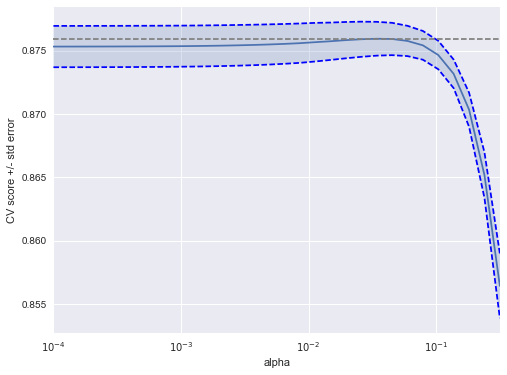

In [25]:
lasso = Lasso(random_state=42)
alphas = np.logspace(-4, -0.5, 30)

scores = list()
scores_std = list()

n_folds = 3

for alpha in alphas:
    lasso.alpha = alpha
    this_scores = cross_val_score(lasso, X, y, cv=n_folds, n_jobs=1)
    scores.append(np.mean(this_scores))
    scores_std.append(np.std(this_scores))

scores, scores_std = np.array(scores), np.array(scores_std)

plt.figure().set_size_inches(8, 6)
plt.semilogx(alphas, scores)

# plot error lines showing +/- std. errors of the scores
std_error = scores_std / np.sqrt(n_folds)

plt.semilogx(alphas, scores + std_error, 'b--')
plt.semilogx(alphas, scores - std_error, 'b--')

# alpha=0.2 controls the translucency of the fill color
plt.fill_between(alphas, scores + std_error, scores - std_error, alpha=0.2)

plt.ylabel('CV score +/- std error')
plt.xlabel('alpha')
plt.axhline(np.max(scores), linestyle='--', color='.5')
plt.xlim([alphas[0], alphas[-1]])

/usr/local/anaconda2/lib/python2.7/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


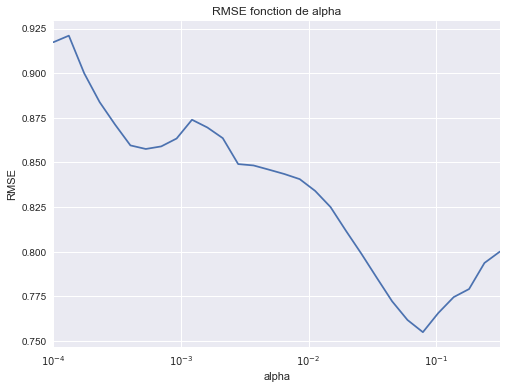

In [26]:
lasso = Lasso(random_state=42)
alphas = np.logspace(-4, -0.5, 30)

#feature polynomial d'ordre 2
polynomial_features = PolynomialFeatures(degree=2, include_bias=False)
X0_train_ = polynomial_features.fit_transform(X0_train)
X0_test_ = polynomial_features.fit_transform(X0_test)

#list
rmse = list()
MAPE = list()

n_folds = 3

for alpha in alphas:
    #lasso = LassoCV(random_state=42, cv=10)
    lasso.alpha = alpha
    lasso.fit(X0_train_,y0_train)
    y_lr=lasso.predict(X0_test_)
    rmse.append(RMSE(y0_test, y_lr))
    MAPE.append(mape_error(y0_test, y_lr))
rmse, MAPE = np.array(rmse), np.array(MAPE)

plt.figure().set_size_inches(8, 6)


# plot error lines showing +/- std. errors of the scores

plt.semilogx(alphas, rmse)
#plt.semilogx(alphas, MAPE)

# alpha=0.2 controls the translucency of the fill color

plt.ylabel('RMSE')
plt.xlabel('alpha')
plt.xlim([alphas[0], alphas[-1]])
plt.title('RMSE fonction de alpha')

In [27]:
#alphas qui minimise la RMSE:
alpha=alphas[rmse.argmin()]
#Evaluation du modèle :
print("L'erreur type (RMSE) est de %s") %((rmse.min()))
print("La moyenne absolue de pourcentage d'erreur est de %s %%") %(MAPE[rmse.argmin()])
print("Meilleur model utilisant alpha = %s." % (alpha))

L'erreur type (RMSE) est de 0.75495372119
La moyenne absolue de pourcentage d'erreur est de 10.87538921 %
Meilleur model utilisant alpha = 0.0788046281567.


**Test de stabilité sur une autre coupe de test**

L'erreur type (RMSE) est de 0.757727352894
La moyenne absolue de pourcentage d'erreur est de 13.9652341999 %
Meilleur model utilisant alpha = 0.137382379588.


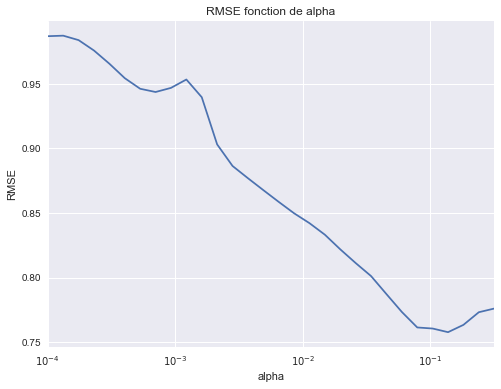

In [28]:
X0_train,X0_test,y0_train,y0_test=train_test_split(X,y,test_size=0.3,random_state=1024) #nouvelle coupe

lasso = Lasso(random_state=42)
alphas = np.logspace(-4, -0.5, 30)

#feature polynomial d'ordre 2
polynomial_features = PolynomialFeatures(degree=2, include_bias=False)
X0_train_ = polynomial_features.fit_transform(X0_train)
X0_test_ = polynomial_features.fit_transform(X0_test)

#list
rmse = list()
MAPE = list()

n_folds = 3

for alpha in alphas:
    #lasso = LassoCV(random_state=42, cv=10)
    lasso.alpha = alpha
    lasso.fit(X0_train_,y0_train)
    y_lr=lasso.predict(X0_test_)
    rmse.append(RMSE(y0_test, y_lr))
    MAPE.append(mape_error(y0_test, y_lr))
rmse, MAPE = np.array(rmse), np.array(MAPE)

plt.figure().set_size_inches(8, 6)

plt.semilogx(alphas, rmse)
#plt.semilogx(alphas, MAPE)
plt.ylabel('RMSE')
plt.xlabel('alpha')
plt.xlim([alphas[0], alphas[-1]])
plt.title('RMSE fonction de alpha')

#alphas qui minimise la RMSE:
alpha=alphas[rmse.argmin()]
#Evaluation du modèle :
print("L'erreur type (RMSE) est de %s") %((rmse.min()))
print("La moyenne absolue de pourcentage d'erreur est de %s %%") %(MAPE[rmse.argmin()])
print("Meilleur model utilisant alpha = %s." % (alpha))

** Le modèle est stable.**

- > ***Interprétation : record pour le moment obtenu par la régression lasso sur donnée polynomiale d'ordre2.***

- ## B. Méthodes non-linéaires : méthodes ensemblistes  <a name="ensemblistes"></a>

***Ici, nous allons faire usage de méthodes non-linéaires d'apprentissage automatique, et nous verrons quelle est la meilleure méthode en termes de performances (notamment en termes de taux d'erreur et de vitesse d'exécution).***

In [29]:
X0_train,X0_test,y0_train,y0_test=train_test_split(X,y,test_size=0.2,random_state=42) #ancienne coupe

In [30]:
from sklearn.ensemble import RandomForestRegressor, RandomForestRegressor, GradientBoostingRegressor 
from sklearn.cross_validation import KFold
from sklearn.externals import joblib
from xgboost.sklearn import XGBRegressor
from sklearn.metrics import mean_squared_error
import xgboost as xgb

***Commençons par tester la méthode de régression des fôrets aléatoires.***  <a name="RF"></a>

In [31]:
%%time
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor(n_estimators=300, max_depth=7, n_jobs=-1, max_features=None,criterion='mse',
                               min_samples_split=5,random_state=42)
rf.fit(X0_train, y0_train)
y_rf = rf.predict(X0_test)
print("L'erreur type (RMSE) est de %s") %(RMSE(y0_test, y_rf))
print("La moyenne absolue de pourcentage d'erreur est de %s %%") %(mape_error(y0_test, y_rf))

L'erreur type (RMSE) est de 3.70060163635
La moyenne absolue de pourcentage d'erreur est de 65.2701745488 %
CPU times: user 1.67 s, sys: 184 ms, total: 1.85 s
Wall time: 1.31 s


- > ***Interprétations : résultats vraiment décevants, on va chercher à tuner un peu le model.***

- **GridSearch et Cross Validation**

In [32]:
%%time
rf = RandomForestRegressor(criterion='mse', max_features=None,random_state=42)
n_estimators = [50, 100, 150, 200,300,400]
max_depth = [2, 4, 6, 8,10]
min_samples_split=[2,4,6,8]
param_grid = dict(max_depth=max_depth, n_estimators=n_estimators, min_samples_split=min_samples_split)
model = GridSearchCV(rf, param_grid, n_jobs=-1, cv=10,scoring='neg_mean_squared_error') #neg_mean_squared_error pour
                                                                                        #sklearn > 0.18
model.fit(X0_train, y0_train)
y_rf = model.predict(X0_test)
print("L'erreur type (RMSE) est de %s") %(RMSE(y0_test, y_rf))
print("La moyenne absolue de pourcentage d'erreur est de %s %%") %(mape_error(y0_test, y_rf))

L'erreur type (RMSE) est de 3.37445243297
La moyenne absolue de pourcentage d'erreur est de 48.4478180378 %
CPU times: user 10.2 s, sys: 1.57 s, total: 11.7 s
Wall time: 3min 2s


In [33]:
print("Meilleur model utilisant %s." % ( model.best_params_))

Meilleur model utilisant {'min_samples_split': 2, 'n_estimators': 300, 'max_depth': 10}.


- > ***Nous obtenons une MAPE d'environ 50 % et un RMSE de 3.4. C'est légèrement mieux, mais encore une fois cela reste horrible.***

***Cette fois, testons toujours la méthode de régression extra-trees, mais cette fois, avec un nombre d'estimateurs plus important (porté à 300), et une profondeur maximale bien plus réduite (profondeur maximale de 7).***

In [34]:
%%time
from sklearn.ensemble import ExtraTreesRegressor

et = ExtraTreesRegressor(n_estimators=300, criterion='mse',max_depth=7,n_jobs=-1,
                         min_samples_split=5,max_features=None)
et.fit(X0_train, y0_train)
y_et = et.predict(X0_test)
print("L'erreur type (RMSE) est de %s") %(RMSE(y0_test, y_et))
print("La moyenne absolue de pourcentage d'erreur est de %s %%") %(mape_error(y0_test, y_et))

L'erreur type (RMSE) est de 3.70115639068
La moyenne absolue de pourcentage d'erreur est de 47.883046621 %
CPU times: user 1.22 s, sys: 221 ms, total: 1.45 s
Wall time: 1.28 s


- **GridSearch et Cross Validation**

In [35]:
%%time
et = ExtraTreesRegressor(criterion='mse',max_features=None)
n_estimators = [100, 150, 200,300,400]
max_depth = [4, 6, 8,10]
min_samples_split=[2,4,6,8]
param_grid = dict(max_depth=max_depth, n_estimators=n_estimators, min_samples_split=min_samples_split)
model = GridSearchCV(et, param_grid, n_jobs=-1, cv=10,scoring='neg_mean_squared_error')
model.fit(X0_train, y0_train)
y_et = model.predict(X0_test)
print("L'erreur type (RMSE) est de %s") %(RMSE(y0_test, y_et))
print("La moyenne absolue de pourcentage d'erreur est de %s %%") %(mape_error(y0_test, y_et))

L'erreur type (RMSE) est de 3.0186503078
La moyenne absolue de pourcentage d'erreur est de 37.6594584788 %
CPU times: user 6.98 s, sys: 1.03 s, total: 8.01 s
Wall time: 1min 56s


In [36]:
print("Meilleur model utilisant %s." % ( model.best_params_))

Meilleur model utilisant {'min_samples_split': 2, 'n_estimators': 300, 'max_depth': 10}.


- > ***Nous obtenons une MAPE d'environ 36 %. L'erreur est meilleure (entendre "plus faible") lorsque la profondeur est importante, mais que le nombre d'estimateurs n'est pas colossal, néanmoins une grande profondeur tend à overfitter.***

***Pour le XG Boost: ***<a name="XGB"></a>

In [37]:
%%time
xg = xgb.XGBRegressor(max_depth=3, n_estimators=300, learning_rate=0.05).fit(X0_train, y0_train)
y_xgb = xg.predict(X0_test)
print("L'erreur type (RMSE) est de %s") %(RMSE(y0_test, y_xgb))
print("La moyenne absolue de pourcentage d'erreur est de %s %%") %(mape_error(y0_test, y_xgb))

L'erreur type (RMSE) est de 3.33001941733
La moyenne absolue de pourcentage d'erreur est de 24.6096246593 %
CPU times: user 363 ms, sys: 912 ms, total: 1.28 s
Wall time: 508 ms


- > ***Nous obtenons un pourcentage d'erreur d'environ 24 % et une MSE de 3,3. C'est un progrès net. Le modèle XGBoost semble une piste à creuser.***

In [38]:
%%time
xg = xgb.XGBRegressor(seed=42,nthread=-1)
n_estimators = [100, 150, 200,300,400]
max_depth = [3,4, 6, 8,10]
param_grid = dict(max_depth=max_depth, n_estimators=n_estimators)
model = GridSearchCV(xg, param_grid, cv=10,scoring='neg_mean_squared_error') # n_jobs=-1,
model.fit(X0_train, y0_train)
y_xgb = model.predict(X0_test)
print("L'erreur type (RMSE) est de %s") %(RMSE(y0_test, y_xgb))
print("La moyenne absolue de pourcentage d'erreur est de %s %%") %(mape_error(y0_test, y_xgb))

L'erreur type (RMSE) est de 2.5826903108
La moyenne absolue de pourcentage d'erreur est de 36.3425237123 %
CPU times: user 2min 27s, sys: 7min, total: 9min 28s
Wall time: 3min 50s


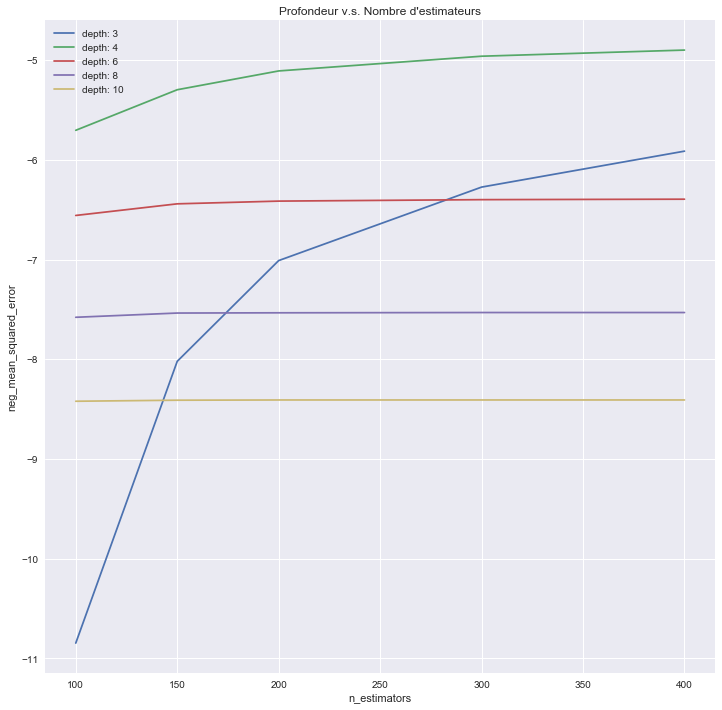

In [39]:
means = model.cv_results_['mean_test_score']
stds = model.cv_results_['std_test_score']
params = model.cv_results_['params']
#for mean, stdev, param in zip(means, stds, params):
#    print("%f (%f) with: %r" % (mean, stdev, param))
# plot results
plt.figure(figsize = (12,12))
scores = np.array(means).reshape(len(max_depth), len(n_estimators))
for i, value in enumerate(max_depth):
    plt.plot(n_estimators, scores[i], label='depth: ' + str(value))
plt.legend()
plt.xlabel('n_estimators')
plt.ylabel('neg_mean_squared_error')
plt.title("Profondeur v.s. Nombre d'estimateurs")

In [40]:
%%time
xg = xgb.XGBRegressor(seed=42,nthread=-1)
n_estimators = [100, 150, 200,300,400]
max_depth = [3,4, 6, 8,10]
learning_rate=[0.05,0.075]
param_grid = dict(max_depth=max_depth, n_estimators=n_estimators,learning_rate=learning_rate)
model = GridSearchCV(xg, param_grid, cv=10,scoring='neg_mean_squared_error') # n_jobs=-1,
model.fit(X0_train, y0_train)
y_xgb = model.predict(X0_test)
print("L'erreur type (RMSE) est de %s") %(RMSE(y0_test, y_xgb))
print("La moyenne absolue de pourcentage d'erreur est de %s %%") %(mape_error(y0_test, y_xgb))

L'erreur type (RMSE) est de 2.70045076166
La moyenne absolue de pourcentage d'erreur est de 34.5481954018 %
CPU times: user 5min 19s, sys: 15min 11s, total: 20min 31s
Wall time: 8min 20s


In [41]:
print("Meilleur model utilisant %s." % ( model.best_params_))

Meilleur model utilisant {'n_estimators': 400, 'learning_rate': 0.075, 'max_depth': 4}.


- > ***Nous obtenons une MAPE d'environ 34 % mais un RMSE des plus faibles avec 2.7. C'est très légèrement moins bien que la régression linéaire que l'on a sélectionné plus haut (degré polynomial 2, cv10 et sans normalisation).***

**Test du XGBoost avec des features polynomiales :**

L'intuition voudrait que le fait de dériver des features polynomiales à partir de la donnée brute soit innéficace pour les méthodes de types ensemblistes.

In [42]:
%%time
xg = xgb.XGBRegressor(seed=42,nthread=-1)
polynomial_features = PolynomialFeatures(degree=2, include_bias=False)
X0_train_ = polynomial_features.fit_transform(X0_train)
X0_test_ = polynomial_features.fit_transform(X0_test)

n_estimators = [100, 150, 200,300,400]
max_depth = [3,4, 6, 8,10]
learning_rate=[0.05,0.075]
param_grid = dict(max_depth=max_depth, n_estimators=n_estimators,learning_rate=learning_rate)

model = GridSearchCV(xg, param_grid, cv=10,scoring='neg_mean_squared_error') # n_jobs=-1,
model.fit(X0_train_, y0_train)
y_xgb = model.predict(X0_test_)

print("L'erreur type (RMSE) est de %s") %(RMSE(y0_test, y_xgb))
print("La moyenne absolue de pourcentage d'erreur est de %s %%") %(mape_error(y0_test, y_xgb))
print("Meilleur model utilisant %s." % ( model.best_params_))

L'erreur type (RMSE) est de 2.74161583376
La moyenne absolue de pourcentage d'erreur est de 26.4636237958 %
Meilleur model utilisant {'n_estimators': 400, 'learning_rate': 0.075, 'max_depth': 4}.
CPU times: user 30min 50s, sys: 17min 37s, total: 48min 28s
Wall time: 11min 45s


- > *** Interprétation : notre intuition s'est révélée être correcte, dériver des features polynomiales n'apportent rien au modèle ensembliste.***

# III. Evaluation des modèles retenus

** On étudie les deux modèles aux plus grande performances**

- - ### Modèle Linéaire :

In [43]:
#interprétations des coéfficients
def pretty_print_linear(coefs, names = None, sort = False,filter_=True,threshold=0.005):
    if names == None:
        names = ["X%s" % x for x in range(len(coefs))]
    lst = zip(coefs, names)
    if sort:
        lst = sorted(lst,  key = lambda x:-np.abs(x[0]))
    
    df=pd.DataFrame()
    df['coef'],df['var'] = map(list, zip(*lst))
    if filter_:
        df = df[abs(df['coef'])>threshold]
        df.reset_index(inplace=True,drop=True)
    return df
 


In [44]:
#Reprise du modèle linéaire
lr = LinearRegression() #init
polynomial_features = PolynomialFeatures(degree=2, include_bias=False)
X_ = polynomial_features.fit_transform(X)
#X0_test_ = polynomial_features.fit_transform(X0_test)

#grid = dict(linear_regression__normalize=[False,True]) #espace de paramètre de la régression
                                                        # choix sur la normalisation
#model = GridSearchCV(pipe,param_grid=grid,cv=8)
lr.fit(X_, y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [45]:
#Reconstruire le tableau avec le nom des variables
target_feature_names = ['x'.join(['{}^{}'.format(pair[0],pair[1]) for pair in tuple if pair[1]!=0]) for tuple in [zip(X.columns,p) for p in polynomial_features.powers_]]
output_df = pd.DataFrame(X_, columns = target_feature_names)

In [46]:
print "Linear model:"
pretty_print_linear(lr.coef_,names = list(output_df.columns),sort=True,threshold=0.01)

Linear model:


,coef,var
0,1.821908,Categorie socio professionnelle_Sans emploi^1
1,1.821908,Categorie socio professionnelle_Sans emploi^2
2,1.415284,Categorie socio professionnelle_Etudiant^2
3,1.415284,Categorie socio professionnelle_Etudiant^1
4,0.917433,Categorie socio professionnelle_Etudiant^1xMar...
5,-0.876557,Marque_Opel^1
6,-0.876557,Marque_Opel^2
7,0.743791,Type de vehicule_SUV^1xMarque_Toyota^1
8,0.705983,Type de vehicule_Utilitaire^1xMarque_Toyota^1
9,-0.661634,Categorie socio professionnelle_Travailleur no...


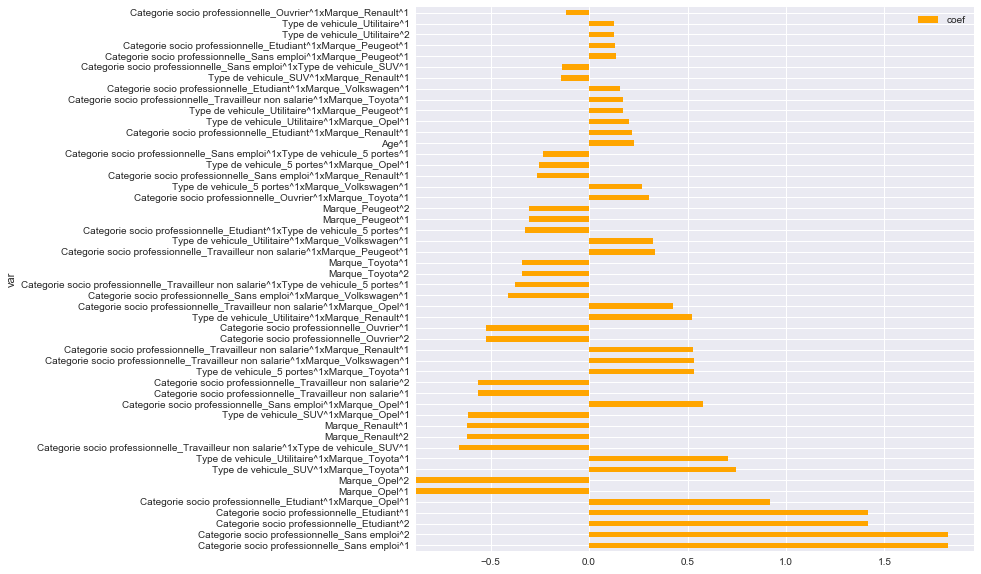

In [47]:
importance_frame = pretty_print_linear(lr.coef_,names = list(output_df.columns),sort=True,threshold=0.01)
#importance_frame.sort_values(by = 'Importance', inplace = True)
importance_frame[0:50].plot(kind = 'barh', x = 'var', figsize = (10,10), color = 'orange')

- > ***La lecture des coefficients est peu satisfante***

- - ### Modèle linéaire Lasso

In [48]:
lasso = Lasso(random_state=42)
alphas = np.logspace(-4, -0.5, 30)

rmse = list()
MAPE = list()
lr = list()

n_folds = 3

for alpha in alphas:
    lasso.alpha = alpha
    lasso.fit(X0_train_,y0_train)
    lr.append(lasso)
    y_lr=lasso.predict(X0_test_)
    rmse.append(RMSE(y0_test, y_lr))
    MAPE.append(mape_error(y0_test, y_lr))
rmse, MAPE = np.array(rmse), np.array(MAPE)

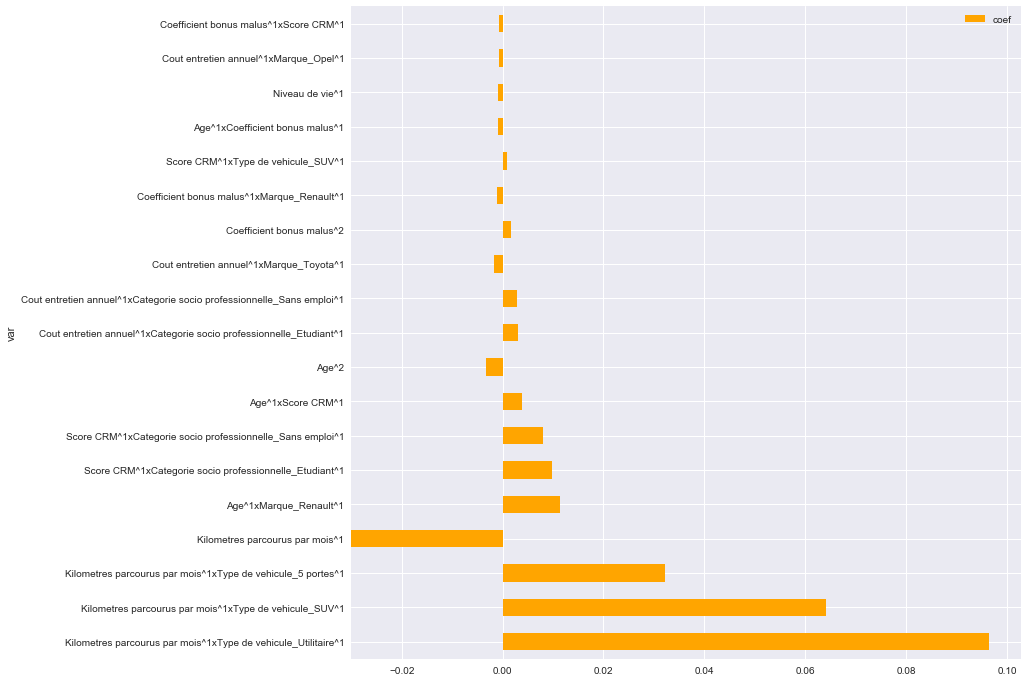

In [49]:
#alphas qui minimise la RMSE:
alpha=alphas[rmse.argmin()]
#Evaluation du modèle :
best_regressor = lr[rmse.argmin()]

importance_frame = pretty_print_linear(best_regressor.coef_,names = list(output_df.columns),sort=True,threshold=0.0006)
#importance_frame.sort_values(by = 'Importance', inplace = True)
importance_frame[0:50].plot(kind = 'barh', x = 'var', figsize = (12,12), color = 'orange')

- > ***La lecture des coefficients est bien plus satisfaisante avec la régression Lasso, les interprétations à valeurs métiers ont ici un sens.***

- - ### Modèle XGBoost :

- ## Plot des features selon leur importance

***Dans cette étape d'évaluation du modèle, nous allons représenter sous la forme d'un diagramme horizontal les variables qui contribuent le plus au modèle, à l'aide de la méthode XGBoost.***

In [50]:
%%time
dtrain = xgb.DMatrix(X0_train,label=y0_train)
dtest = xgb.DMatrix(X0_test)

params = {'booster':'gbtree', 'eta':0.2, 'max_depth':4, 'subsample':0.8, 'n_estimators':400,
                 'silent':1, 'objective':'reg:linear', "seed":42, 'nhtread':12,
                 'eval_metric':'rmse','colsample_bytree':0.7}
    
xg = xgb.train(params, dtrain, 400)
y_xg = xg.predict(dtest)
print("L'erreur type (RMSE) est de %s") %(RMSE(y0_test, y_xg))
print("La moyenne absolue de pourcentage d'erreur est de %s %%") %(mape_error(y0_test, y_xg))

L'erreur type (RMSE) est de 4.60515672847
La moyenne absolue de pourcentage d'erreur est de 47.251523022 %
CPU times: user 548 ms, sys: 1.66 s, total: 2.21 s
Wall time: 918 ms


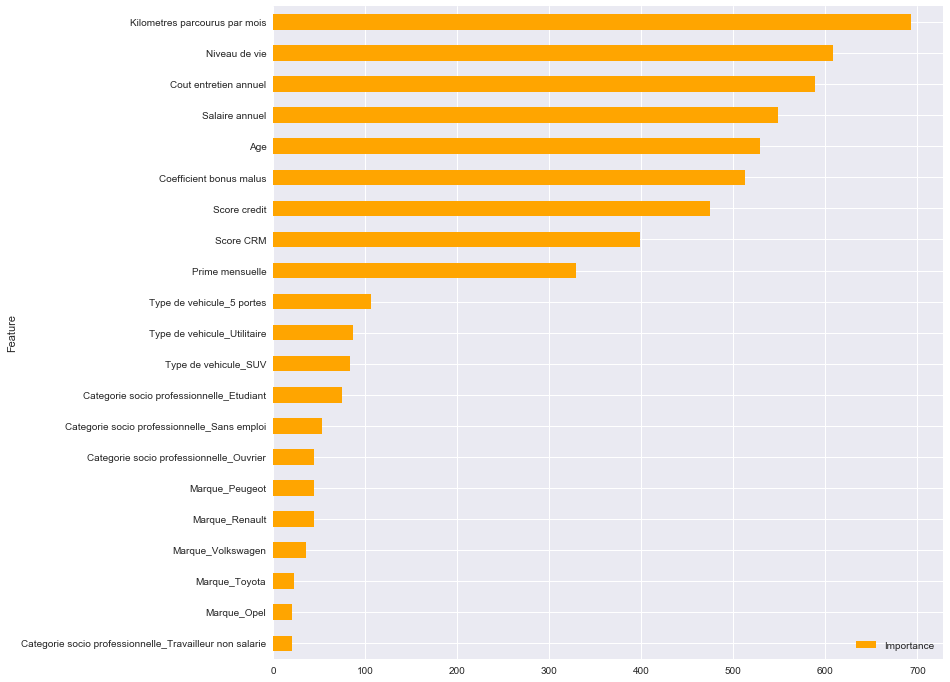

In [51]:
importances = xg.get_score()
importance_frame = pd.DataFrame({'Importance': list(importances.values()),'Feature': list(importances.keys())})
importance_frame.sort_values(by = 'Importance', inplace = True)
importance_frame[0:75].plot(kind = 'barh', x = 'Feature', figsize = (12,12), color = 'orange')

- > ***L'importances des features pour le modèle XGBoost semblent être en adéquation avec le sens métier qu'elles apportent au calcul du bénifice net annuel. En effet, on peut interpréter :***
    - Le kilométrage influe sur le risque / proba d'accidents
    - Coût d'entretient est directement lié au bénéfice net annuel étant donné que plus la voiture est coûteuse à entretenir / réparer plus cela impactera le calcul de bénéfice (soit augmentation de la prime d'assurance, soit coût de l'assureur à réparer en cas d'accidents)
    - etc...

# IV. Soumission des résultats

In [57]:
path='../models/Final submit/'

In [58]:
def write_to_file(X_prod,y_pred,name_file,path) :
    if not os.path.exists(path):
        os.makedirs(path)
    X_prod['Benefice net annuel predit'] = y_pred
    X_prod[['Benefice net annuel predit']].to_csv(path+name_file, index=True, sep='|')
    print('Ecriture finie.')
    return

In [59]:
%%time
lr = LinearRegression() #init
polynomial_features = PolynomialFeatures(degree=2, include_bias=False)
# Création du pipeline
pipe = Pipeline([("polynomial_features", polynomial_features),
        ("linear_regression", lr)])
grid = dict(linear_regression__normalize=[False,True]) #espace de paramètre de la régression
                                                        # choix sur la normalisation
model = GridSearchCV(pipe,param_grid=grid,cv=8)
model.fit(X, y)
#predict
y_lr_simple = model.predict(T)
write_to_file(T.copy(), y_lr_simple,'ma_prediction_RL_simple.csv',path)

Ecriture finie.
CPU times: user 3.33 s, sys: 52.6 ms, total: 3.38 s
Wall time: 580 ms


In [60]:
%%time
lasso = Lasso(random_state=42)

#poly features
polynomial_features = PolynomialFeatures(degree=2, include_bias=False)
X_ = polynomial_features.fit_transform(X)
T_ = polynomial_features.fit_transform(T)



lasso.alpha = alpha #alpha minimisant la rmse sur le test d'apprentissage
lasso.fit(X_,y)
y_lr=lasso.predict(T_)



#predicteur minimisant la
#predict
y_lr_lasso = model.predict(T)
write_to_file(T.copy(), y_lr_lasso,'ma_prediction_RL_lasso.csv',path)

Ecriture finie.
CPU times: user 180 ms, sys: 2.71 ms, total: 183 ms
Wall time: 150 ms


In [61]:
df=pd.DataFrame()
df['Lasso']=y_lr_lasso
df['Simple']=y_lr_simple
df['diff'] = df['Lasso'] -df['Simple']
df[df['diff']!=0]

,Lasso,Simple,diff


# <font color='red'>IMPORTANT : </font> 

- > **cf. fichier de conclusion**